Pipeline:

1. Baseline model 
    - read file 
    - separate training and validation dataset 
    - Logistic regression 
        - RFE Feature selection 
        - Hyperparameter tuning 
    - Interpretation 
        - by weights 
        - by SHAP 
2. Other ML classifiers 

In [1]:
import pandas as pd
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import string 
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from regressors import stats
from sklearn.feature_selection import chi2

In [2]:
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option("display.max_colwidth", 200)

import altair as alt
import time

# pip install ipython-autotime
import autotime
from sklearn.feature_selection import RFECV

from sklearn.metrics import make_scorer, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve

from itertools import compress
import matplotlib
import matplotlib.pyplot as plt

import shap
shap.initjs()

In [483]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [396]:
def show_scores(model, X_train, y_train, X_test, y_test, show=True):
    """
    Calculate the scores 
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    score_result = {"accuracy":[], "recall":[], "precision":[], "roc_auc_score":[], "f1_score":[]}
    score_result["accuracy"].append(round(accuracy_score(y_train, y_pred_train), 2))
    score_result["accuracy"].append(round(accuracy_score(y_test, y_pred_test), 2))
    score_result["recall"].append(round(recall_score(y_train, y_pred_train), 2))
    score_result["recall"].append(round(recall_score(y_test, y_pred_test), 2))
    score_result["precision"].append(round(precision_score(y_train, y_pred_train), 2))
    score_result["precision"].append(round(precision_score(y_test, y_pred_test), 2))
    score_result["roc_auc_score"].append(round(roc_auc_score(y_train, y_pred_train), 2))
    score_result["roc_auc_score"].append(round(roc_auc_score(y_test, y_pred_test), 2))
    score_result["f1_score"].append(round(f1_score(y_train, y_pred_train), 2))
    score_result["f1_score"].append(round(f1_score(y_test, y_pred_test), 2))
    if show:
        score_result = pd.DataFrame(score_result, index=["train", "valid"])
        return score_result
    else:
        return 

In [671]:
def show_weights(feat_names, weights, num):
    #feat_names #= X_train_sel_cols
    #weights #= lr.coef_.flatten()

    # Sort the coefficients in descending order 
    inds = np.argsort(weights)

    # pick the first 20 as most informative features for negative reviews  
    negative_words = [feat_names[index] for index in inds[:num]]

    # pick the last 20 features as most informative features for positive reviews  
    positive_words = [feat_names[index] for index in inds[-num:][::-1]]

    neg_words_weights = [(weights[index]) for index in inds[:num]]
    pos_words_weights = [(weights[index]) for index in inds[-num:][::-1]]

    df = pd.DataFrame({'Neg feats':negative_words, 'Neg weights':neg_words_weights, 
                       'Pos feats':positive_words, 'Pos weights':pos_words_weights})
    return df

In [747]:
# Train data 
df = pd.read_csv("../data/0604_training_dataset.csv")

X = df[['accounting_concentration',
       'arts_concentration', 'business_concentration',
       'computer_systems_concentration', 'engineering_concentration',
       'finance_concentration', 'general_concentration',
       'human_resource_concentration',
       'interactive_arts_and_technology_concentration',
       'marketing_concentration', #'not_specified_concentration',
       'other_concentration',#education concentration 
               'administrative', 'assistant manager', 'blue collar', 'cashier', 'cook',
               'customer service representative', 'driver', 'education',
               'financial services', 'fitness/sports', 'manager', 'no work', 'other',
               'sales associate', 'technicians', 'telemarketers', # work_title 
               'sales_exp', 'customer_serv_exp','leader_ship_exp', #sales_cus_exp
               #'efficient service', 'mobile expert', 'high school',
                #'information system', 'cash register', # word count
               'raw_date_chall_readability', # communication level 
               'food_service_industry_exp',
               'apparel_industry_exp', 'supercenter_convenience_industry_exp',
               'automotive_sales_industry_exp', 'blue_collar_industry_exp',
               'consumer_electronics', #industry_exp
               'no_lang_spoken', 'trilingual_flag', 'goal_record',
               'sales_customer_base_exp', 'volunteer_exp', 'problem_solver',
               'sports_mention', 'communication_skills', 'team_player',
               'leadership_mention','competitor_experience', 'highest_degree', 'country_highest_degree', 'rehired_', 'background_highest_degree']]
X=X.dropna()

In [748]:
df2 =df[['highest_degree', 'country_highest_degree', 'rehired_', 'background_highest_degree']].dropna()

In [749]:
X = X.reset_index(drop=True)
ohe = OneHotEncoder(sparse=False, dtype=int)
data = ohe.fit_transform(df2[['highest_degree', 'country_highest_degree', 'rehired_', 'background_highest_degree']])
cols = ohe.get_feature_names(['highest_degree', 'country_highest_degree', 'rehired_', 'background_highest_degree'])
df3 = pd.DataFrame(data, columns=cols).reset_index(drop=True)

In [753]:
X = pd.concat([X, df3], axis=1)
X = X.drop(columns = ['highest_degree', 'country_highest_degree', 'rehired_', 'background_highest_degree'])

In [758]:
X = df[['accounting_concentration',
       'arts_concentration', 'business_concentration',
       'computer_systems_concentration', 'engineering_concentration',
       'finance_concentration', 'general_concentration',
       'human_resource_concentration',
       'interactive_arts_and_technology_concentration',
       'marketing_concentration', #'not_specified_concentration',
       'other_concentration',#education concentration 
               'administrative', 'assistant manager', 'blue collar', 'cashier', 'cook',
               'customer service representative', 'driver', 'education',
               'financial services', 'fitness/sports', 'manager', 'no work', 'other',
               'sales associate', 'technicians', 'telemarketers', # work_title 
               'sales_exp', 'customer_serv_exp','leader_ship_exp', #sales_cus_exp
               #'efficient service', 'mobile expert', 'high school',
                #'information system', 'cash register', # word count
               'raw_date_chall_readability', # communication level 
               'food_service_industry_exp',
               'apparel_industry_exp', 'supercenter_convenience_industry_exp',
               'automotive_sales_industry_exp', 'blue_collar_industry_exp',
               'consumer_electronics', #industry_exp
               'no_lang_spoken', 'trilingual_flag', 'goal_record',
               'sales_customer_base_exp', 'volunteer_exp', 'problem_solver',
               'sports_mention', 'communication_skills', 'team_player',
               'leadership_mention','competitor_experience']]

In [759]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [761]:
vif[vif["VIF Factor"]>=5]

,VIF Factor,features
24,8.975287,sales associate
30,9.346355,raw_date_chall_readability
37,18.896859,no_lang_spoken
38,6.903969,trilingual_flag
40,10.734379,sales_customer_base_exp
45,6.038152,team_player


In [819]:
# Split data 
X_train = df.drop(columns=["hp_class"])
y_train = df["hp_class"]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                         train_size=0.8, random_state=1234)


In [964]:
numeric_features =['referral_flag', 
               "job_hopper",               #avg_work 
               'competitor_experience',
               #'Freedom_competitor_exp', 'Koodo_competitor_exp', 'Shaw_competitor_exp',
               #'Telus_competitor_exp', 'Bell_competitor_exp', 'Rogers_competitor_exp',
               #'The Mobile Shop_competitor_exp', 'Best Buy_competitor_exp',
               #'Videotron_competitor_exp', 'Wow[!]* Mobile_competitor_exp',
               #'The Source_competitor_exp', 'Walmart_competitor_exp',
               #'Virgin Mobile_competitor_exp', 'Osl_competitor_exp',    #competitor_experience
               'accounting_concentration',
       'arts_concentration', 'business_concentration',
       'computer_systems_concentration', 'engineering_concentration',
       'finance_concentration', 'general_concentration',
       'human_resource_concentration',
       'interactive_arts_and_technology_concentration',
       'marketing_concentration', #'not_specified_concentration',
       'other_concentration',#education concentration 
               'administrative', 'assistant manager', 'blue collar', 'cashier', 'cook',
               'customer service representative', 'driver', 'education',
               'financial services', 'fitness/sports', 'manager', 'no work', 'other',
               'sales associate', 'technicians', 'telemarketers', # work_title 
               'sales_exp', 'leader_ship_exp',#sales_cus_exp
               #'efficient service', 'mobile expert', 'high school','customer_serv_exp',
                #'information system', 'cash register', # word count
               'raw_date_chall_readability', # communication level 
               'food_service_industry_exp',
               'apparel_industry_exp', 'supercenter_convenience_industry_exp',
               'automotive_sales_industry_exp', 'blue_collar_industry_exp',
               'consumer_electronics', #industry_exp
               'no_lang_spoken', 'trilingual_flag', 'goal_record',
               'volunteer_exp', 'problem_solver',
               'sports_mention', 'communication_skills', 'team_player',
               'leadership_mention']# others features in consolidate dataset  'sales_customer_base_exp',
                   # new_industry_cat updated
                #'Clothing & Footwear_industry_exp',
       #'Consumer electronics_industry_exp', 'Food Service_industry_exp',
       #'Food-Convenience-Pharmacy_industry_exp', 'Other_industry_exp',
       #'Sport_Travel_Enterntain_Hotel_industry_exp',
       #'Telecommunications_industry_exp', 'unknown_industry_exp'] 
                
categorical_features = ['rehired_', 'highest_degree', 'country_highest_degree', 'background_highest_degree'] #'background_highest_degree', 'country_highest_degree']

In [965]:
# Preprocess 
numeric_transformer = Pipeline(steps=[
                                      ('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())
                                    ])


categorical_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy='constant', 
                                                                    fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

preprocessor = ColumnTransformer(
                                 transformers=[
                                    ('num', numeric_transformer, numeric_features),
                                    ('cat', categorical_transformer, categorical_features)
                                ])

In [979]:
clf_featr_sele = LogisticRegression(solver='liblinear', penalty="l1") 
rfecv = RFECV(estimator=clf_featr_sele, 
              step=1, 
              cv=5, 
              scoring = 'roc_auc'
             )

weights = np.linspace(0.1, 0.5, 9)
lg_param_grid = {"C": [0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 10],
                'class_weight': [{0: x, 1: 1.0-x} for x in weights],
                 'l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                 'penalty':["l1", "l2"]
                }
CV_rfc = GridSearchCV(clf_featr_sele, 
                      lg_param_grid,
                     cv= 5, scoring = 'roc_auc')


In [980]:
# Baseline model 
clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('feature_sele',rfecv),
                         ('clf_cv',CV_rfc)])


In [981]:
clf.fit(X_train, y_train);


Text(0.5, 1.0, 'Confusion matrix for high performer training data set')

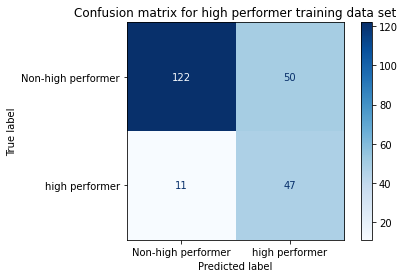

In [982]:
disp = plot_confusion_matrix(clf, X_train, y_train,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer training data set')


Text(0.5, 1.0, 'Confusion matrix for high performer validation data set')

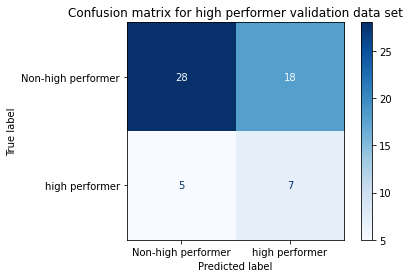

In [983]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer validation data set')

In [984]:
#predictions = clf.predict(X_train)
#print(classification_report(y_train, predictions))
#predictions = clf.predict(X_valid)
#print(classification_report(y_valid, predictions))
print("Best param is: ", CV_rfc.best_params_)

Best param is:  {'C': 0.5, 'class_weight': {0: 0.25, 1: 0.75}, 'l1_ratio': 0, 'penalty': 'l2'}


In [985]:
show_scores(clf, X_train, y_train, X_valid, y_valid)

,accuracy,recall,precision,roc_auc_score,f1_score
train,0.73,0.81,0.48,0.76,0.61
valid,0.60,0.58,0.28,0.60,0.38


In [986]:
# Take out the training dataset after preprocessing 
X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train),
                           index=X_train.index,
                           columns=(numeric_features +
                                      list(preprocessor.named_transformers_['cat']['onehot']
                                           .get_feature_names(categorical_features))))
X_valid_trans = pd.DataFrame(preprocessor.fit(X_train).transform(X_valid),
                           index=X_valid.index,
                           columns=(numeric_features +
                                      list(preprocessor.named_transformers_['cat']['onehot']
                                           .get_feature_names(categorical_features))))

In [993]:
X_train_sel = X_train_trans.to_numpy()[:, rfecv.support_]
X_valid_sel = X_valid_trans.to_numpy()[:, rfecv.support_]
X_train_sel_cols = list(compress(X_train_trans.columns, rfecv.support_))
lr = LogisticRegression(solver='liblinear', C = 0.5, class_weight = {0: 0.25, 1: 0.75}, l1_ratio=0, penalty="l2") 
lr.fit(X_train_sel, y_train);

In [994]:
len(X_train)

230

Text(0.5, 1.0, 'Confusion matrix for high performer validation data set')

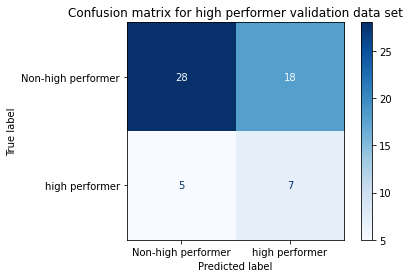

In [995]:
disp = plot_confusion_matrix(lr, X_valid_sel, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer validation data set')

In [996]:
# Show feature weights 
feat_names = X_train_sel_cols
weights = lr.coef_.flatten()
show_weights(feat_names, weights, 10)

,Neg feats,Neg weights,Pos feats,Pos weights
0,highest_degree_highschool,-0.521586,competitor_experience,0.550626
1,supercenter_convenience_industry_exp,-0.518139,cashier,0.425890
2,food_service_industry_exp,-0.482731,trilingual_flag,0.411843
3,interactive_arts_and_technology_concentration,-0.355096,consumer_electronics,0.407252
4,rehired__Yes,-0.307322,finance_concentration,0.321073
5,automotive_sales_industry_exp,-0.232170,country_highest_degree_canada,-0.227693
6,country_highest_degree_canada,-0.227693,automotive_sales_industry_exp,-0.232170
7,finance_concentration,0.321073,rehired__Yes,-0.307322
8,consumer_electronics,0.407252,interactive_arts_and_technology_concentration,-0.355096
9,trilingual_flag,0.411843,food_service_industry_exp,-0.482731


In [991]:
def show_probs(employee_code, y_obs, y_pred, probs, dataset = "train"):
    '''
    Show probabilities 
    '''
    if dataset == "train":
        df1 = pd.DataFrame({"employee_code": employee_code, "y_obs_train": y_obs, "y_pred_train":y_pred}).reset_index(drop=True)
        df2 = pd.DataFrame(columns=["non-high performer", "high performer"],  data=probs)
        df_prob = pd.concat([df1, df2], axis =1)
        df_prob["False_positive"] = df_prob.apply(lambda row: 1 if row.y_obs_train == 0 and row.y_pred_train == 1 else 0, axis=1)
        df_prob["False_negative"] = df_prob.apply(lambda row: 1 if row.y_obs_train == 1 and row.y_pred_train == 0 else 0, axis=1)
    elif dataset == "valid":
        df1 = pd.DataFrame({"employee_code": employee_code, "y_obs_valid": y_obs, "y_pred_valid":y_pred}).reset_index(drop=True)
        df2 = pd.DataFrame(columns=["non-high performer", "high performer"],  data=probs)
        df_prob = pd.concat([df1, df2], axis =1)
        df_prob["False_positive"] = df_prob.apply(lambda row: 1 if row.y_obs_valid == 0 and row.y_pred_valid ==1 else 0, axis=1)
        df_prob["False_negative"] = df_prob.apply(lambda row: 1 if row.y_obs_valid == 1 and row.y_pred_valid ==0 else 0, axis=1)
    return df_prob

In [992]:
# Show probabilities for training set 
show_probs(X_train.employee_code, y_train, lr.predict(X_train_sel), lr.predict_proba(X_train_sel))

,employee_code,y_obs_train,y_pred_train,non-high performer,high performer,False_positive,False_negative
0,N07,0.0,1.0,0.247441,0.752559,1,0
1,MW5,1.0,0.0,0.718397,0.281603,0,1
2,NAD,0.0,0.0,0.749597,0.250403,0,0
3,MQM,0.0,0.0,0.749597,0.250403,0,0
4,N7F,1.0,0.0,0.501674,0.498326,0,1
...,...,...,...,...,...,...,...
225,N1E,0.0,0.0,0.749597,0.250403,0,0
226,N37,0.0,0.0,0.852349,0.147651,0,0
227,MUQ,0.0,0.0,0.839177,0.160823,0,0
228,MXC,1.0,0.0,0.749383,0.250617,0,1


In [120]:
# Show probabilities for validation set (here is test set)
df = show_probs(X_valid.employee_code, y_valid, lr.predict(X_valid_sel), lr.predict_proba(X_valid_sel), dataset="valid")

In [121]:
df[df.False_negative==1]

,employee_code,y_obs_valid,y_pred_valid,non-high performer,high performer,False_positive,False_negative
22,N7F,1.0,0.0,0.731775,0.268225,0,1
41,MXA,1.0,0.0,0.675623,0.324377,0,1
48,N7Y,1.0,0.0,0.653094,0.346906,0,1


In [122]:
#df1 = pd.DataFrame({"employee_code": X_train.employee_code, "y_obs_train": y_train, "y_pred_train":lr.predict(X_train_sel)}).reset_index(drop=True)
#df2 =pd.DataFrame(columns=["non-high performer", "high performer"],  data=lr.predict_proba(X_train_sel))
#df_prob_train = pd.concat([df1, df2], axis =1)

In [123]:
## Explain the Linear model 
explainer = shap.LinearExplainer(lr, X_train_sel, feature_dependence="independent")
shap_values = explainer.shap_values(X_valid_sel)
X_valid_array = X_valid_sel # we need to pass a dense version for the plotting functions

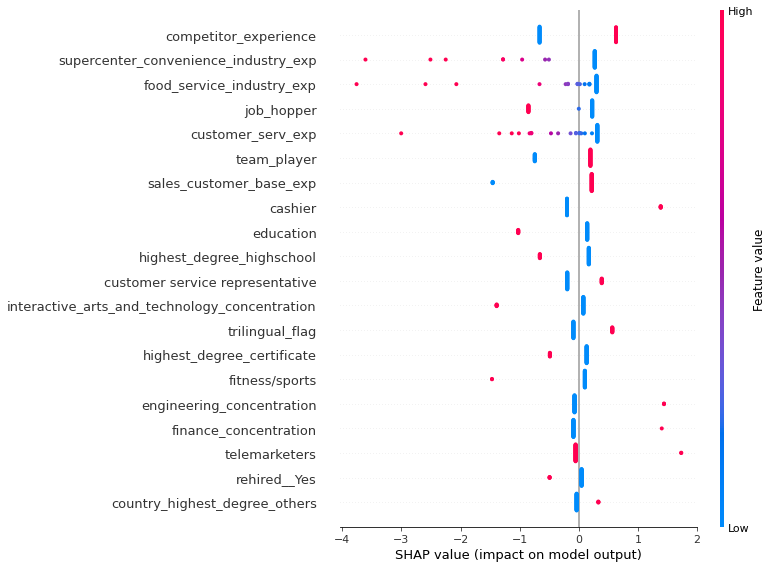

In [124]:
shap.summary_plot(shap_values, X_valid_array, feature_names=X_train_sel_cols)

In [125]:
# Let's take a look at false negative case 
ind = 22
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_valid_array[ind,:],
    feature_names=X_train_sel_cols
)

In [115]:
# Let's take a look at false negative case 
ind = 41
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_valid_array[ind,:],
    feature_names=X_train_sel_cols
)

In [827]:
# Let's take a look at false negative case 
ind = 48
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_valid_array[ind,:],
    feature_names=X_train_sel_cols
)

--- 

# Random Forest !!!
bagging and random forest~

use SMOTE???

[link](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/#:~:text=An%20easy%20way%20to%20overcome,drawn%20from%20the%20original%20dataset)

In [988]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [994]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
#smote_model = LogisticRegression(class_weight="balanced", C = 0.05, solver='saga', penalty='elasticnet', l1_ratio=0.2, max_iter=500)
#smote_model.fit(X_train_sm, y_train_sm);


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/haoyusu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-994-0a2bcdc843f6>", line 2, in <module>
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
  File "/Users/haoyusu/anaconda3/lib/python3.7/site-packages/imblearn/base.py", line 77, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
  File "/Users/haoyusu/anaconda3/lib/python3.7/site-packages/imblearn/base.py", line 134, in _check_X_y
    X, y = check_X_y(X, y, accept_sparse=accept_sparse)
  File "/Users/haoyusu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 755, in check_X_y
    estimator=estimator)
  File "/Users/haoyusu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 531, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "/Users/haoyusu/anaconda3/lib/python3.

ValueError: could not convert string to float: 'MRI'

## Try other ML classifiers

In [126]:
models = {
          #'decision tree': DecisionTreeClassifier(class_weight="balanced"),
          #'kNN': KNeighborsClassifier(),
          #'logistic regression': LogisticRegression(class_weight="balanced", solver='liblinear'),
          #'RBF SVM' : SVC(), 
          'random forest' : RandomForestClassifier(), 
          'xgboost' : XGBClassifier(),
          'lgbm': LGBMClassifier()
         }

       accuracy  recall  precision  roc_auc_score  f1_score
train      1.00    1.00       1.00           1.00      1.00
valid      0.62    0.08       0.08           0.42      0.08
       accuracy  recall  precision  roc_auc_score  f1_score
train      0.90    0.60       1.00           0.80      0.75
valid      0.81    0.33       0.57           0.63      0.42
       accuracy  recall  precision  roc_auc_score  f1_score
train      0.79    1.00       0.55           0.86      0.71
valid      0.47    0.25       0.12           0.39      0.16


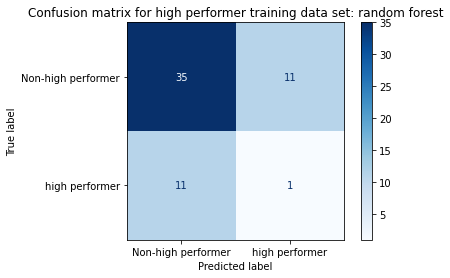

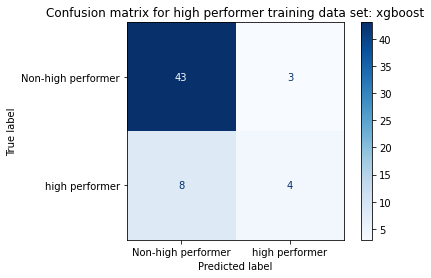

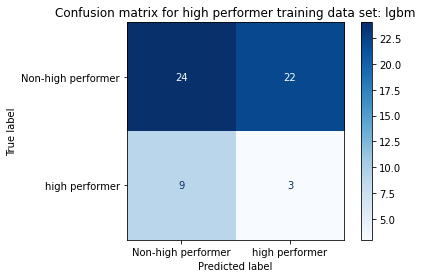

In [127]:
results_dict = {}
for model_name, model in models.items(): 
    rfecv = RFECV(estimator=model, 
              step=1, 
              cv=5, 
              scoring = 'f1')
    weights = np.linspace(0.1, 0.5, 9)
    lg_param_grid = {#"C": [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 10],
                    'class_weight': [{0: x, 1: 1.0-x} for x in weights],
                    }
    CV_rfc = GridSearchCV(model, 
                          lg_param_grid,
                         cv= 5, scoring = 'f1')
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          #('clf_cv',CV_rfc),
                          #('classifier', model),
                          ('feature_sele',rfecv),
                          ('clf_cv',CV_rfc)
                         ])
    clf.fit(X_train, y_train.to_numpy().ravel());
    print(show_scores(clf, X_train, y_train, X_valid, y_valid))
    disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
    disp.ax_.set_title('Confusion matrix for high performer training data set: '+model_name)